In [5]:
import skyfield.api
from skyfield.api import wgs84
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import math

from calc_sat_view import calc_sat_view
from draw_sat_view import draw_sat_view

[#################################] 100% gnss.txt


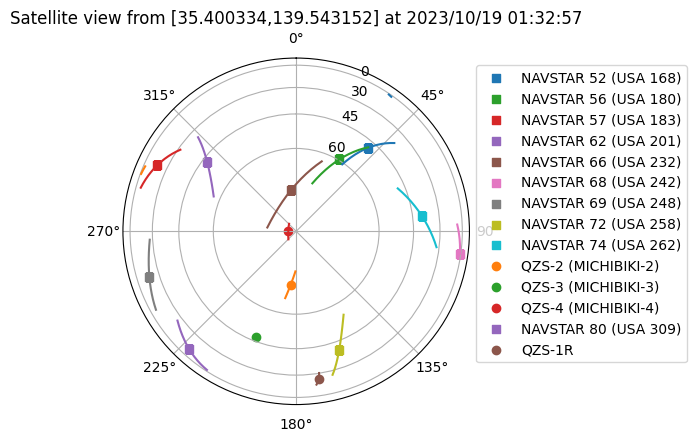

In [6]:
now = datetime.now()
draw_sat_view(calc_sat_view(now), now)

1セル完結版

[#################################] 100% gnss.txt


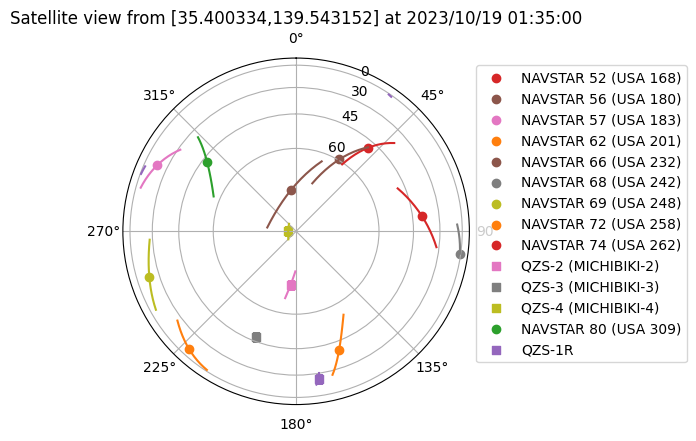

In [7]:
# 地上の緯度経度
view_from_lat = 35.400334
view_from_lon = 139.543152

# 表示する最低仰角
min_disp_alt_deg = 5

# 計算時刻間隔[秒]
interval_sec = 5*60
# 過去側計算回数
past_generate_count = 6  
# 未来側計算回数  
future_generate_count = 6

# 描画用対象衛星定義
calc_sats = [
    'NAVSTAR',
    'QZS',
]

dt = datetime.now()
sats = skyfield.api.load.tle_file("https://celestrak.org/NORAD/elements/gnss.txt", reload=True)
rounded_datetime = datetime.fromtimestamp(((dt.timestamp() + interval_sec) // interval_sec) * interval_sec, tz=timezone(timedelta(hours=9)))
ts = skyfield.api.load.timescale()
tss = ts.from_datetimes(
    [rounded_datetime - timedelta(minutes=5 * i) for i in range(-past_generate_count,future_generate_count+1)]
)
current_ts = ts.from_datetime(rounded_datetime)


shape_table = {
    'NAVSTAR':'o',
    'QZS':',',
}

rtick_deg = [90,60,45,30,0]
fig = plt.figure(figsize=[8,4.5])
ax = fig.add_subplot(projection='polar')
ax.set_theta_offset(math.pi/2)
ax.set_theta_direction(-1)
ax.set_rticks([math.cos(deg/180 * math.pi) for deg in rtick_deg],[str(deg) for deg in rtick_deg])
plt.title("Satellite view from [{},{}] at {}".format(view_from_lat, view_from_lon, rounded_datetime.strftime('%Y/%m/%d %H:%M:%S')))

cmap = plt.get_cmap("tab10")
cidx = 0

view_from = wgs84.latlon(view_from_lat,view_from_lon) 

for sat in sats:
    shape = ''
    for sat_key in shape_table.keys():
        if sat.name.startswith(sat_key):
            shape = shape_table[sat_key]
            break
    if 0 < len(shape):
        alts = []
        azs = []
        difference = sat - view_from
        prev_appended = False
        for target_ts in tss:
            topocentric = difference.at(target_ts)
            alt, az, _ = topocentric.altaz()
            if min_disp_alt_deg < alt.degrees:
                alts.append(math.cos(alt.degrees/180 * math.pi))
                azs.append(az.degrees/180 * math.pi)
                prev_appended = True
            else:
                if prev_appended and 0 < len(alts) and 0 < len(azs):
                    prev_appended = False
                    ax.plot(azs, alts, color=cmap(cidx))
                    alts = []
                    azs = []
        if 0 < len(alts) and 0 < len(azs):
            ax.plot(azs, alts, color=cmap(cidx))
            alts = []
            azs = []

        target_ts = current_ts
        topocentric = difference.at(target_ts)
        alt, az, distance = topocentric.altaz()
        if min_disp_alt_deg < alt.degrees:
            ax.scatter([az.degrees/180 * math.pi],[math.cos(alt.degrees/180 * math.pi)], marker=shape, label=sat.name, color=cmap(cidx))
        cidx += 1
        cidx %= 10

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


# 以下検討時のバックアップ